In [1]:
# To check if Jupyter notebook is running in the right environment
import sys
print(sys.executable)

/Users/isikm/opt/anaconda/envs/sampl6_pKa/bin/python


In [2]:
import numpy as np
import pandas as pd
from openeye import oechem
from openeye import oemolprop

## Checking correlation of molecular MAE with molecular descriptors

Molecular descriptors I wish to check:
- molecular weight
- number of heavy atom
- number of rotatable bonds 
- number of heteroatoms (not C or H)
- number of ring systems (contiguous systems of ring atoms and bonds)
- max ring size (Maximum size of any single ring system)
- number of microstates

In [3]:
# Functions required for molecular weight calculation

# Maximum and minumum values stated here actually doesn't matter 
# because I won't filter molecules.
def get_filter_rules():

    FILTER_RULES = """
# This file defines the rules for filtering multi-structure files based on
# properties and substructure patterns.

MIN_MOLWT      130       "Minimum molecular weight"
MAX_MOLWT      781       "Maximum molecular weight"

MIN_XLOGP      -3.0      "Minimum XLogP"
MAX_XLOGP       6.85     "Maximum XLogP"

PSA_USE_SandP   false    "Count S and P as polar atoms"
MIN_2D_PSA      0.0      "Minimum 2-Dimensional (SMILES) Polar Surface Area"
MAX_2D_PSA      205.0    "Maximum 2-Dimensional (SMILES) Polar Surface Area"

# choices are insoluble<poorly<moderately<soluble<very<highly
MIN_SOLUBILITY insoluble "Minimum solubility"

MIN_LIPINSKI_DONORS  0      "Minimum number of hydrogens on O & N atoms"
MAX_LIPINSKI_DONORS  6      "Maximum number of hydrogens on O & N atoms"

MIN_LIPINSKI_ACCEPTORS  1   "Minimum number of oxygen & nitrogen atoms"
MAX_LIPINSKI_ACCEPTORS  14  "Maximum number of oxygen & nitrogen atoms"

MAX_LIPINSKI   3         "Maximum number of Lipinski violations"

MIN_NUM_HVY 9 "Minimum number of heavy atoms"
MAX_NUM_HVY 55 "Maximum number of heavy atoms"

MIN_HETEROATOMS 1 "Minimum number of heteroatoms"
MAX_HETEROATOMS 14 "Maximum number of heteroatoms"

MIN_Het_C_Ratio 0.04 "Minimum heteroatom to carbon ratio"
MAX_Het_C_Ratio 4.0 "Maximum heteroatom to carbon ratio"

MIN_HBOND_ACCEPTORS 0 "Minimum number of hydrogen-bond acceptors"
MAX_HBOND_ACCEPTORS 13 "Maximum number of hydrogen-bond acceptors"

MIN_HBOND_DONORS 0 "Minimum number of hydrogen-bond donors"
MAX_HBOND_DONORS 9 "Maximum number of hydrogen-bond donors"

MIN_RING_SYS 0 "Minimum number of ring systems"
MAX_RING_SYS 5 "Maximum number of ring systems"

MIN_RING_SIZE 0 "Minimum atoms in any ring system"
MAX_RING_SIZE 20 "Maximum atoms in any ring system"

MIN_ROT_BONDS 0 "Minimum number of rotatable bonds"
MAX_ROT_BONDS 16 "Maximum number of rotatable bonds"
"""
    return FILTER_RULES

In [4]:
# Exploring property calculation

# Create OE mol object from SMILES
smiles = "c1cc2c(cc1O)c3c(o2)C(=O)NCCC3"
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, str(smiles))

# Calculate molecular weight

ifs = oechem.oeisstream(get_filter_rules())
filter = oemolprop.OEFilter(ifs)

ostr = oechem.oeosstream()
pwnd = False
filter.SetTable(ostr, pwnd)

headers = ostr.str().split(b'\t')
ostr.clear()  # remove the header row from the stream

filter(mol)

fields = ostr.str().decode("UTF-8").split('\t')
ostr.clear()  # remove this row from the stream

filterdict = dict(zip(headers, fields))
filterdict.keys

for key in filterdict.keys():
    print(key)

print(filterdict[b"molecular weight"])

b'SMILES'
b'Name'
b'atom count'
b'heteroatoms'
b'heteroatom to carbon ratio'
b'hydrogen-bond acceptors'
b'hydrogen-bond donors'
b'lipinski h-bond acceptors'
b'lipinski h-bond donors'
b'molecular weight'
b'number of ring systems'
b'maximum size of ring system'
b'rotatable bonds'
b'XLogP'
b'Solubility'
b'2d PSA'
b'Lipinski violations'
b'Filter \n'
217.22


In [5]:
# To calculate molecular weight without counter ions, remove counter ions from SMILES.
df = pd.read_csv("molecule_ID_and_SMILES.csv")
df["canonical isomeric SMILES w/o counter ions"] = None

for i in range(df.shape[0]):
    SMILES = df.loc[i, "canonical isomeric SMILES"]
    SMILES_wo_counterions = SMILES.split(".")[0]
    df.loc[i,"canonical isomeric SMILES w/o counter ions"] = SMILES_wo_counterions
df

,SAMPL6 Molecule ID,canonical isomeric SMILES,canonical isomeric SMILES w/o counter ions
0,SM01,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3
1,SM02,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F
2,SM03,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3
3,SM04,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl
4,SM05,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3
5,SM06,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br
6,SM07,c1ccc(cc1)CNc2c3ccccc3ncn2,c1ccc(cc1)CNc2c3ccccc3ncn2
7,SM08,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3
8,SM09,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,COc1cccc(c1)Nc2c3ccccc3ncn2
9,SM10,c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2,c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2


### 1. Molecular Weight 

In [6]:
def calc_mw(mol):
    """
    Calculates molecular weight of given mol object
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    mw = float(filterdict[b"molecular weight"])
    
    return mw

### 2. Number of heavy atoms

In [7]:
def calc_number_of_heavy_atoms(mol):
    """
    Calculates number of heavy atoms (non-H)
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    count = float(filterdict[b"atom count"])
    
    return count

### 3. Number of rotatable bonds 

In [8]:
def calc_number_of_rotatable_bonds(mol):
    """
    Calculates number of rotatable bonds
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    count = float(filterdict[b"rotatable bonds"])
    
    return count

### 4. Number of heteroatoms (not C or H)

In [9]:
def calc_number_of_heteroatom(mol):
    """
    Calculates number of rotatable bonds
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    count = float(filterdict[b"heteroatoms"])
    
    return count

### 5. Heteroatom ratio to carbon ratio

In [10]:
def calc_het_atom_to_carbon_ratio(mol):
    """
    Calculates number of non-terminal rotatable bonds
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    ratio = float(filterdict[b"heteroatom to carbon ratio"])
    
    return ratio

### 6. Number of ring systems

In [11]:
def calc_number_of_ring_systems(mol):
    """
    Calculates number of ring systems (contiguous systems of ring atoms and bonds)
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    count = float(filterdict[b"number of ring systems"])
    
    return count

### 7. Ring size

In [12]:
def calc_max_ring_size(mol):
    """
    Calculates maximum size of any single ring system
    """
    ifs = oechem.oeisstream(get_filter_rules())
    filter = oemolprop.OEFilter(ifs)
    
    ostr = oechem.oeosstream()
    pwnd = False
    filter.SetTable(ostr, pwnd)
    
    headers = ostr.str().split(b'\t')
    ostr.clear()  # remove the header row from the stream
    
    filter(mol)
    
    fields = ostr.str().decode("UTF-8").split('\t')
    ostr.clear()  # remove this row from the stream
    
    filterdict = dict(zip(headers, fields))
    
    size = float(filterdict[b"maximum size of ring system"])
    
    return size

### 8. Number of microstates

In [13]:
def calc_number_of_microstates(mol_ID):
    """
    Uses SAMPL6 input files that list microstate IDs, to count the number of microstates 
    provided for each molecule in SAMPL6 pKa challenge. 
    """
    # Read CSV file that contains list of microstates
    df_microstates = pd.read_csv("./microstates/"+mol_ID+"_microstates.csv")
    microstate_count = df_microstates.shape[0]
    
    return microstate_count

In [14]:
# Add molecular descriptors to DataFrame

df["MW"] = None
df["Heavy atom count"] = None
df["Rotatable bond count"] = None
df["Heteroatom count"] = None
df["Heteroatom to carbon ratio"] = None
df["Ring system count"] = None
df["Max ring size"] = None
df["Microstate count"] = None

for i, row in enumerate(df.iterrows()):
    smiles = df.loc[i,"canonical isomeric SMILES w/o counter ions"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))
    
    # Molecular weight
    try: 
        mw = calc_mw(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            mw = float("NaN")        
    df.loc[i,"MW"] = float(mw)
    
    # Number of heavy atoms
    try: 
        heavy_atom_count = calc_number_of_heavy_atoms(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            heavy_atom_count = float("NaN")         
    df.loc[i,"Heavy atom count"] = float(heavy_atom_count)
    
    # Number of rotatable bonds
    try: 
        rot_bond_count = calc_number_of_rotatable_bonds(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            rot_bond_count = float("NaN")
    df.loc[i,"Rotatable bond count"] = float(rot_bond_count)
    
    # Number of heteroatoms
    try: 
        het_atom_count = calc_number_of_heteroatom(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            het_atom_count = float("NaN")
    df.loc[i,"Heteroatom count"] = float(het_atom_count)
    
    # Heteroatom to carbon ratio
    try: 
        het_atom_ratio = calc_het_atom_to_carbon_ratio(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            het_atom_ratio = float("NaN")
    df.loc[i,"Heteroatom to carbon ratio"] = float(het_atom_ratio)
    
    # Number of ring systems
    try: 
        ring_count = calc_number_of_ring_systems(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            ring_count = float("NaN")
    df.loc[i,"Ring system count"] = float(ring_count)
    
    # Maximum ring size
    try: 
        ring_size = calc_max_ring_size(mol)
    except RuntimeError:
            print("Error: i=",i," ", df.ix[i, "NAME"])
            ring_size = float("NaN")
    df.loc[i,"Max ring size"] = float(ring_size)
    
    # Number of microstates collected in SAMPL6 pKa challenge
    mol_ID = row[1]["SAMPL6 Molecule ID"]
    microstate_count = calc_number_of_microstates(mol_ID)
    df.loc[i,"Microstate count"] = float(microstate_count)
    
    del mol
    
df.to_csv("SAMPL6_molecular_descriptors.csv", index=False)
df.head()

,SAMPL6 Molecule ID,canonical isomeric SMILES,canonical isomeric SMILES w/o counter ions,MW,Heavy atom count,Rotatable bond count,Heteroatom count,Heteroatom to carbon ratio,Ring system count,Max ring size,Microstate count
0,SM01,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,217.22,16,0,4,0.33,1,14,8
1,SM02,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,289.26,21,3,6,0.4,2,10,11
2,SM03,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3,301.39,20,4,6,0.43,3,6,16
3,SM04,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,269.73,19,3,4,0.27,2,10,11
4,SM05,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3,304.77,21,3,5,0.31,3,6,9


In [15]:
# Add MAE values to the table

df_MAE = pd.read_csv("molecular_error_statistics.csv")
df_MAE = df_MAE.drop(columns=["Unnamed: 0"])
df_MAE = df_MAE.rename(columns = {"Molecule ID" : "SAMPL6 Molecule ID"})
#df_MAE = df_MAE.sort_values(by=["SAMPL6 Molecule ID"]).reset_index(inplace=True)
df_MAE

,MAE,MAE_lower_CI,MAE_upper_CI,SAMPL6 Molecule ID,RMSE,RMSE_lower_CI,RMSE_upper_CI
0,0.737500,0.527778,0.995556,SM01,1.024875,0.671756,1.415330
1,0.774167,0.532500,1.040278,SM11,1.096002,0.777694,1.371792
2,0.890000,0.646944,1.147778,SM08,1.175214,0.894849,1.429818
3,0.980833,0.737500,1.241667,SM13,1.242584,0.971831,1.499153
4,0.981389,0.817222,1.150556,SM04,1.104354,0.935539,1.271707
5,0.989722,0.846944,1.128889,SM02,1.080454,0.947271,1.207589
6,1.019722,0.779722,1.267778,SM24,1.259545,1.013259,1.490180
7,1.022267,0.849867,1.205467,SM15,1.286979,1.098622,1.473497
8,1.035556,0.837778,1.243333,SM12,1.208578,1.011480,1.394372
9,1.039444,0.856944,1.240833,SM09,1.198077,0.963472,1.452780


In [16]:
df_cor = pd.merge(df, df_MAE, on="SAMPL6 Molecule ID", how="outer" )
df_cor.to_csv("SAMPL6_molecular_descriptors_with_moleculer_statistics.csv", index=False)
df_cor

,SAMPL6 Molecule ID,canonical isomeric SMILES,canonical isomeric SMILES w/o counter ions,MW,Heavy atom count,Rotatable bond count,Heteroatom count,Heteroatom to carbon ratio,Ring system count,Max ring size,Microstate count,MAE,MAE_lower_CI,MAE_upper_CI,RMSE,RMSE_lower_CI,RMSE_upper_CI
0,SM01,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,c1cc2c(cc1O)c3c(o2)C(=O)NCCC3,217.22,16,0,4,0.33,1,14,8,0.737500,0.527778,0.995556,1.024875,0.671756,1.415330
1,SM02,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,c1ccc2c(c1)c(ncn2)Nc3cccc(c3)C(F)(F)F,289.26,21,3,6,0.4,2,10,11,0.989722,0.846944,1.128889,1.080454,0.947271,1.207589
2,SM03,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3,c1ccc(cc1)Cc2nnc(s2)NC(=O)c3cccs3,301.39,20,4,6,0.43,3,6,16,2.350000,1.766944,2.955833,2.982664,2.385172,3.527490
3,SM04,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,c1ccc2c(c1)c(ncn2)NCc3ccc(cc3)Cl,269.73,19,3,4,0.27,2,10,11,0.981389,0.817222,1.150556,1.104354,0.935539,1.271707
4,SM05,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3,c1ccc(c(c1)NC(=O)c2ccc(o2)Cl)N3CCCCC3,304.77,21,3,5,0.31,3,6,9,1.571111,1.242222,1.915278,1.881535,1.555399,2.181617
5,SM06,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,c1cc2cccnc2c(c1)NC(=O)c3cc(cnc3)Br,328.16,20,2,5,0.33,2,10,12,2.006197,1.630704,2.420141,2.624588,2.045935,3.180712
6,SM07,c1ccc(cc1)CNc2c3ccccc3ncn2,c1ccc(cc1)CNc2c3ccccc3ncn2,235.28,18,3,3,0.2,2,10,11,1.494722,1.108333,1.921667,1.944010,1.471524,2.374818
7,SM08,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,Cc1ccc2c(c1)c(c(c(=O)[nH]2)CC(=O)O)c3ccccc3,293.32,22,3,4,0.22,2,10,8,0.890000,0.646944,1.147778,1.175214,0.894849,1.429818
8,SM09,COc1cccc(c1)Nc2c3ccccc3ncn2.Cl,COc1cccc(c1)Nc2c3ccccc3ncn2,251.28,19,3,4,0.27,2,10,11,1.039444,0.856944,1.240833,1.198077,0.963472,1.452780
9,SM10,c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2,c1ccc(cc1)C(=O)NCC(=O)Nc2nc3ccccc3s2,311.36,22,4,6,0.38,2,9,33,2.233056,1.644167,2.904167,2.956409,2.192039,3.695679


### Correlation plots

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = [4,4]

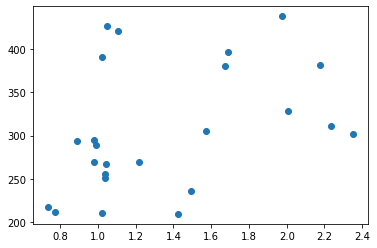

In [18]:
x = df_cor["MAE"]
y = df_cor["MW"]
plt.plot(x,y, "o")

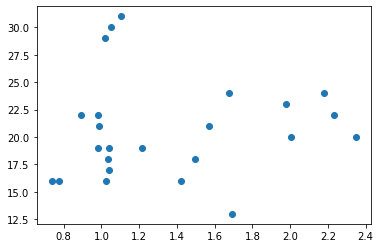

In [19]:
x = df_cor["MAE"]
y = df_cor["Heavy atom count"]
plt.plot(x,y, "o")

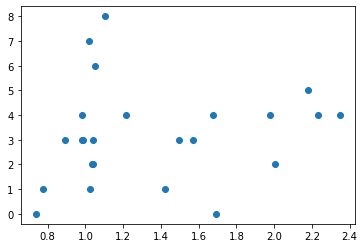

In [20]:
x = df_cor["MAE"]
y = df_cor["Rotatable bond count"]
plt.plot(x,y, "o")

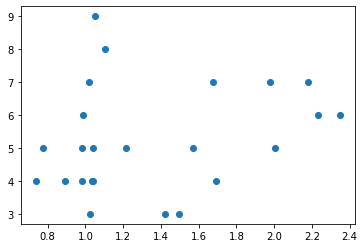

In [21]:
x = df_cor["MAE"]
y = df_cor["Heteroatom count"]
plt.plot(x,y, "o")

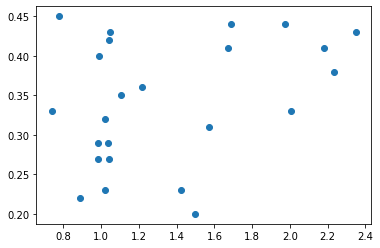

In [22]:
x = df_cor["MAE"]
y = df_cor["Heteroatom to carbon ratio"]
plt.plot(x,y, "o")

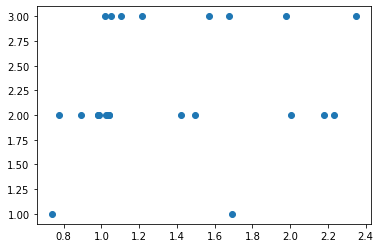

In [23]:
x = df_cor["MAE"]
y = df_cor["Ring system count"]
plt.plot(x,y, "o")

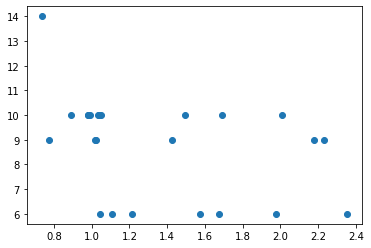

In [24]:
x = df_cor["MAE"]
y = df_cor["Max ring size"]
plt.plot(x,y, "o")

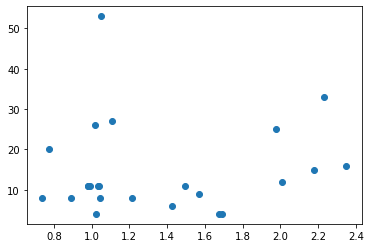

In [25]:
x = df_cor["MAE"]
y = df_cor["Microstate count"]
plt.plot(x,y, "o")

### Calculate R-squared

In [26]:
import scipy.stats

In [27]:
def r2(data):
    x, y = data.T
    slope, intercept, r_value, p_value, stderr = scipy.stats.linregress(x, y)
    return r_value**2

In [28]:
df_cor.dtypes

SAMPL6 Molecule ID                             object
canonical isomeric SMILES                      object
canonical isomeric SMILES w/o counter ions     object
MW                                             object
Heavy atom count                               object
Rotatable bond count                           object
Heteroatom count                               object
Heteroatom to carbon ratio                     object
Ring system count                              object
Max ring size                                  object
Microstate count                               object
MAE                                           float64
MAE_lower_CI                                  float64
MAE_upper_CI                                  float64
RMSE                                          float64
RMSE_lower_CI                                 float64
RMSE_upper_CI                                 float64
dtype: object

In [29]:
df_cor = pd.read_csv("SAMPL6_molecular_descriptors_with_moleculer_statistics.csv", dtype={
    "SAMPL6 Molecule ID": str,
    "canonical isomeric SMILES": str,
    "canonical isomeric SMILES w/o counter ions": str,
    "MW": float,
    "Heavy atom count": int,
    "Rotatable bond count": int,
    "Heteroatom count": int,
    "Heteroatom to carbon ratio": float,
    "Ring system count": int,
    "Max ring size": int,
    "Microstate count": int,
})

In [30]:
df_cor.dtypes

SAMPL6 Molecule ID                             object
canonical isomeric SMILES                      object
canonical isomeric SMILES w/o counter ions     object
MW                                            float64
Heavy atom count                                int64
Rotatable bond count                            int64
Heteroatom count                                int64
Heteroatom to carbon ratio                    float64
Ring system count                               int64
Max ring size                                   int64
Microstate count                                int64
MAE                                           float64
MAE_lower_CI                                  float64
MAE_upper_CI                                  float64
RMSE                                          float64
RMSE_lower_CI                                 float64
RMSE_upper_CI                                 float64
dtype: object

In [31]:
r2_mw = r2(df_cor[["MAE", "MW"]].values)
r2_mw

0.15271174885479796

In [32]:
r2_hac = r2(df_cor[["MAE", "Heavy atom count"]].values)
r2_hac 

0.0038052801378111187

In [33]:
r2_rbc = r2(df_cor[["MAE", "Rotatable bond count"]].values)
r2_rbc

0.017116503868271262

In [34]:
r2_het = r2(df_cor[["MAE", "Heteroatom count"]].values)
r2_het

0.05744909672832589

In [35]:
r2_hetcr = r2(df_cor[["MAE", "Heteroatom to carbon ratio"]].values)
r2_hetcr

0.11506985633903495

In [36]:
r2_ring = r2(df_cor[["MAE", "Ring system count"]].values)
r2_ring

0.04210971814540609

In [37]:
r2_mrs = r2(df_cor[["MAE", "Max ring size"]].values)
r2_mrs

0.1451461239157131

In [38]:
r2_micro = r2(df_cor[["MAE", "Microstate count"]].values)
r2_micro

0.008120808060725527

### Are there any correlation between descriptors and MAE?

In [39]:
def plot_correlation(x, y, data, title=None, color=None, kind='joint', ax=None):
    # Extract only pKa values.
    data = data[[x, y]]

    if kind == 'joint':
        grid = sns.jointplot(x=x, y=y, data=data,
                             kind='reg', joint_kws={'ci': None}, stat_func=None, color=color)
        ax = grid.ax_joint
        grid.fig.subplots_adjust(top=0.95)
        grid.fig.suptitle(title)
    elif kind == 'reg':
        plt.figure(figsize=(3, 3))
        ax = sns.regplot(x=x, y=y, data=data, color=color, ax=ax)
        ax.set_title(title)
        

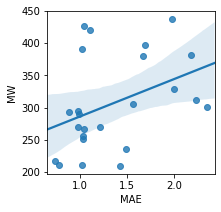

In [40]:
plot_correlation(x="MAE", y="MW", data=df_cor, kind="reg")

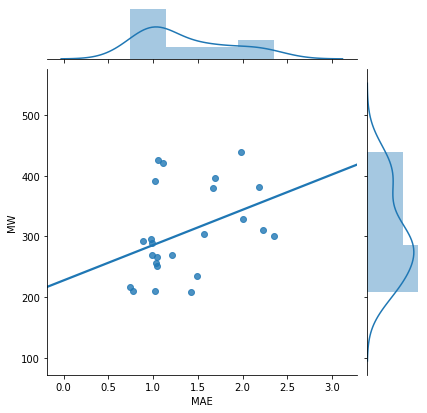

In [41]:
plot_correlation(x="MAE", y="MW", data=df_cor)

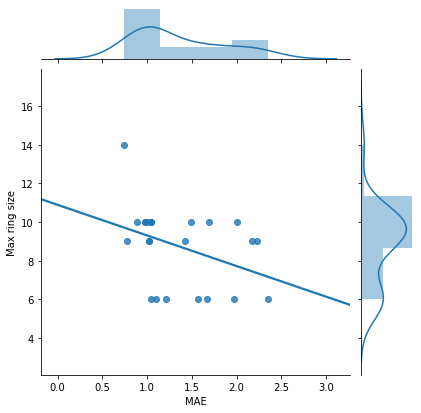

In [42]:
plot_correlation(x="MAE", y="Max ring size", data=df_cor)

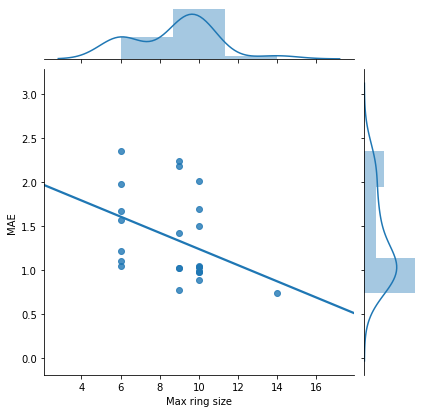

In [43]:
plot_correlation(x="Max ring size", y="MAE", data=df_cor)

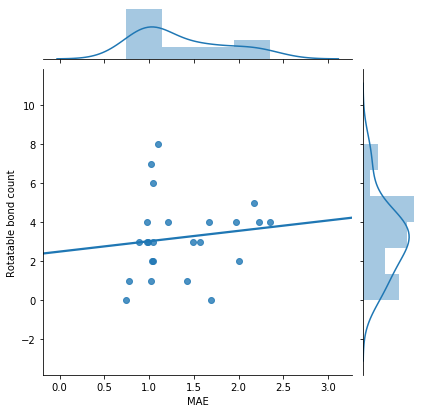

In [44]:
plot_correlation(x="MAE", y="Rotatable bond count", data=df_cor)

### Correlation plots for slides

In [45]:
def plot_correlation(x, y, data, title=None, color=None, kind='joint', ax=None):
    # Extract only pKa values.
    data = data[[x, y]]

    if kind == 'joint':
        grid = sns.jointplot(x=x, y=y, data=data,
                             kind='reg', joint_kws={'ci': None}, stat_func=None, color=color)
        ax = grid.ax_joint
        grid.fig.subplots_adjust(top=0.95)
        grid.fig.suptitle(title)
    elif kind == 'reg':
        plt.figure(figsize=(3, 3),dpi=200)
        ax = sns.regplot(x=x, y=y, data=data, color=color, ax=ax)
        ax.set_title(title)

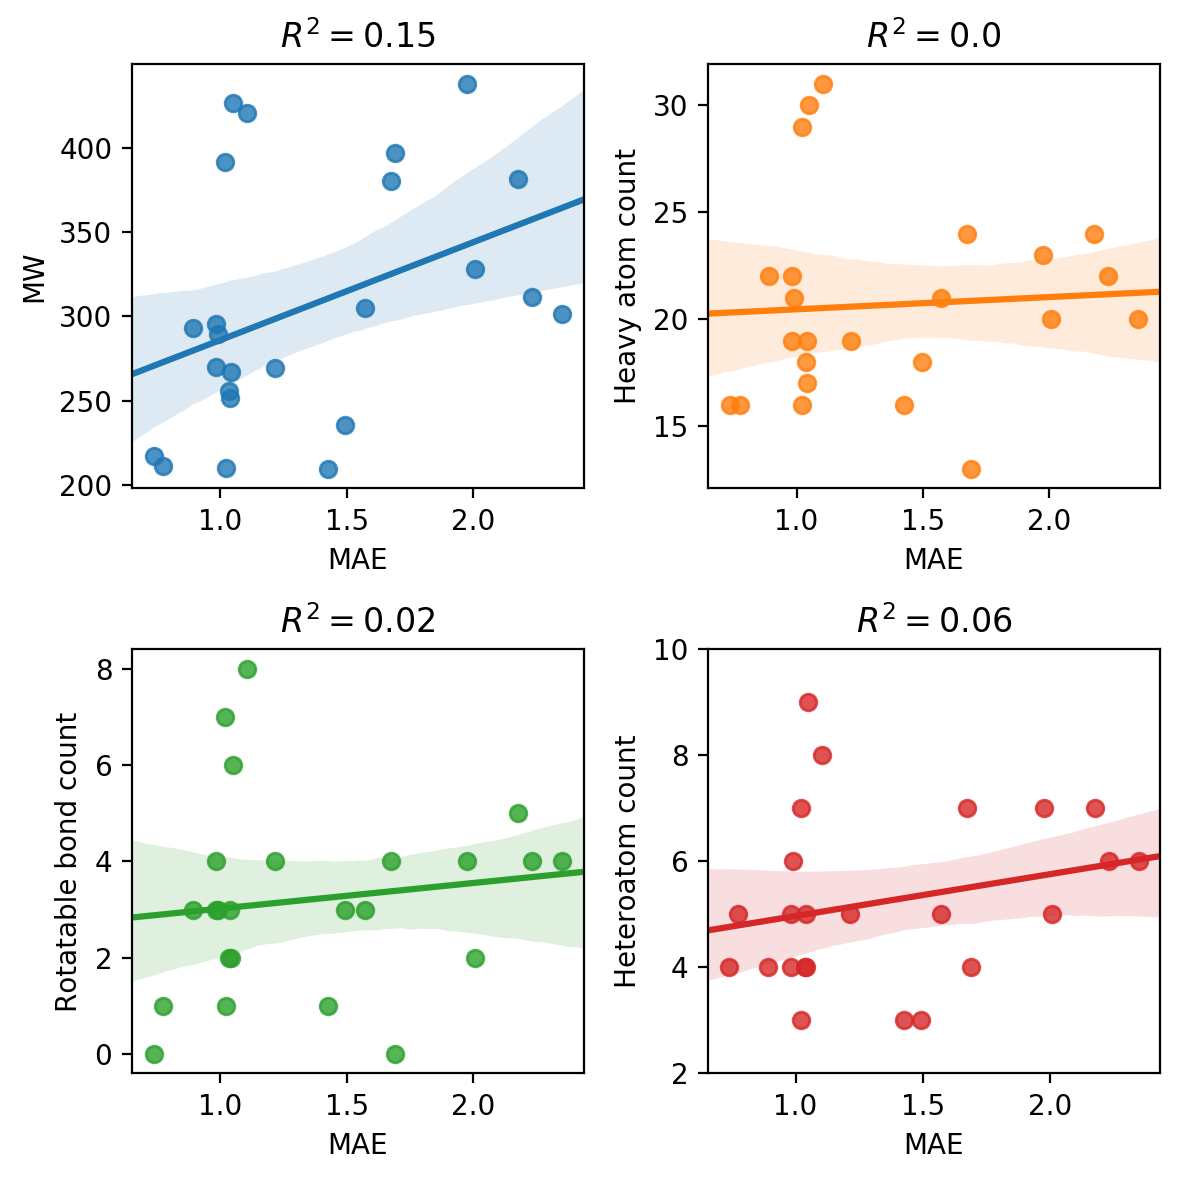

In [48]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(6, 6), dpi=200)

sns.regplot(x="MAE", y="MW", data=df_cor, color=None, ax=ax1)
ax1.set_title("$R^2={}$".format(round(r2_mw,2)))

sns.regplot(x="MAE", y="Heavy atom count", data=df_cor, color=None, ax=ax2)
ax2.set_title("$R^2={}$".format(round(r2_hac ,2)))

sns.regplot(x="MAE", y="Rotatable bond count", data=df_cor, color=None, ax=ax3)
ax3.set_title("$R^2={}$".format(round(r2_rbc,2)))

sns.regplot(x="MAE", y="Heteroatom count", data=df_cor, color=None, ax=ax4)
ax4.set_title("$R^2={}$".format(round(r2_het,2)))
ax4.set_ylim(2,10)

plt.tight_layout()
plt.savefig("molecular_properties_vs_MAE_correlation_plot1.pdf")

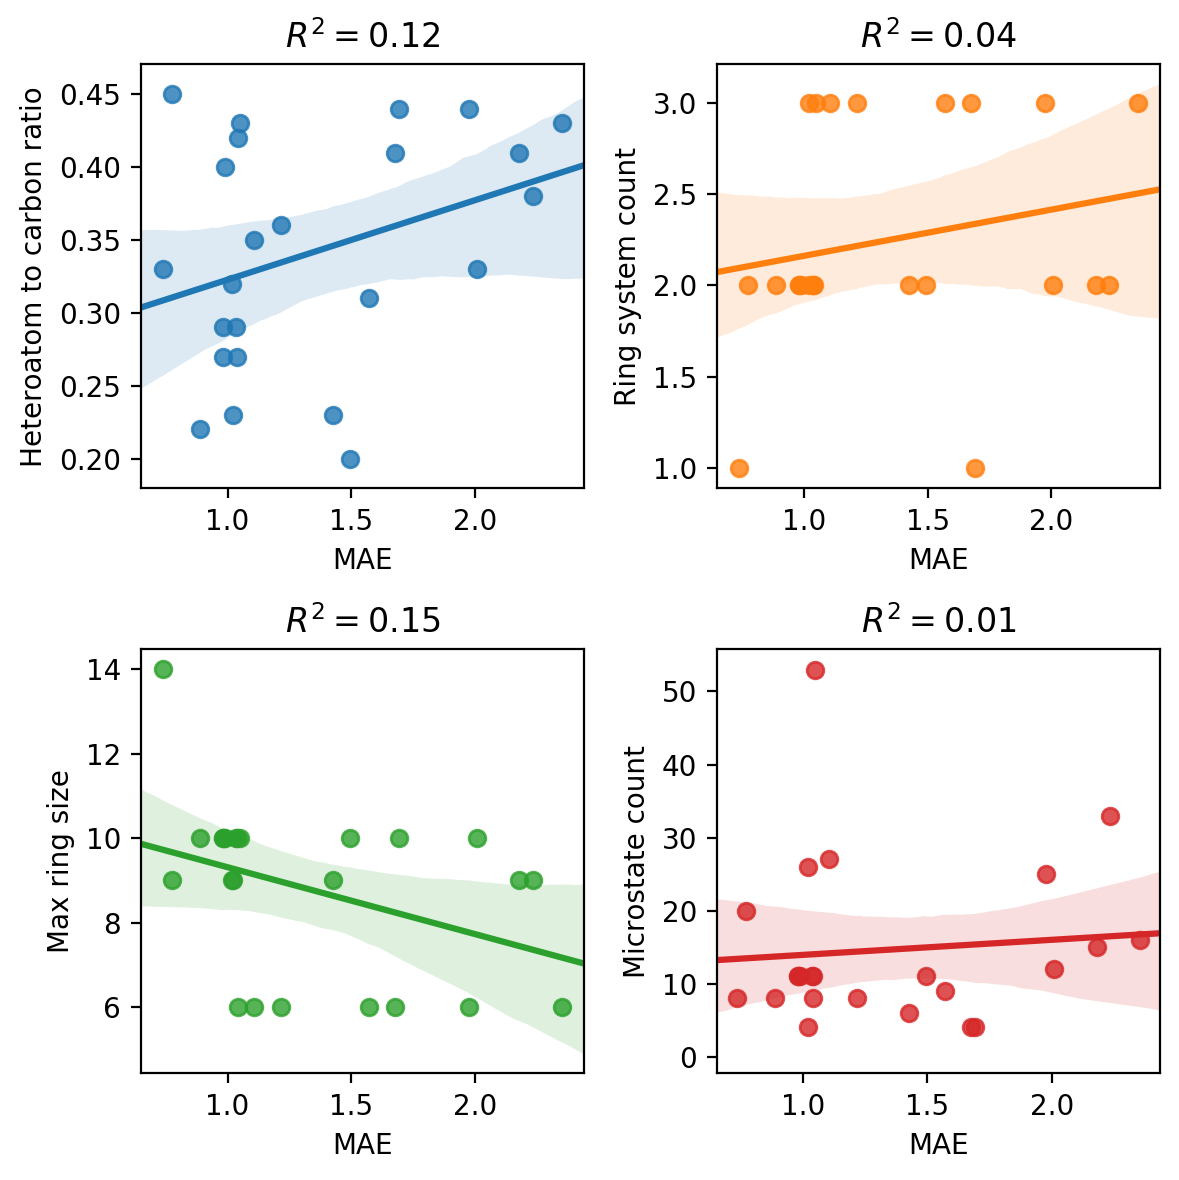

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(6, 6), dpi=200)

sns.regplot(x="MAE", y="Heteroatom to carbon ratio", data=df_cor, color=None, ax=ax1)
ax1.set_title("$R^2={}$".format(round(r2_hetcr,2)))

sns.regplot(x="MAE", y="Ring system count", data=df_cor, color=None, ax=ax2)
ax2.set_title("$R^2={}$".format(round(r2_ring ,2)))

sns.regplot(x="MAE", y="Max ring size", data=df_cor, color=None, ax=ax3)
ax3.set_title("$R^2={}$".format(round(r2_mrs,2)))

sns.regplot(x="MAE", y="Microstate count", data=df_cor, color=None, ax=ax4)
ax4.set_title("$R^2={}$".format(round(r2_micro,2)))
#ax4.set_ylim(2,10)

plt.tight_layout()
plt.savefig("molecular_properties_vs_MAE_correlation_plot2.pdf")